# outline of 'Revealing non-canonical RNA interactions in DMS chemical mapping'

## Extra resources
current draft: https://uofnelincoln-my.sharepoint.com/:w:/r/personal/jyesselman2_unl_edu/_layouts/15/Doc.aspx?sourcedoc=%7B2AAE1849-B2EB-44FC-8A5F-1ED79D0654BC%7D&file=draft_9.docx&action=default&mobileredirect=true

# Notebook setup
NOTE: all data is assumed to be in '../data' and this notebook will not work if the data is in another location!

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
import statsmodels.api as sm

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    plot_scatter_w_best_fit_line,
    format_small_plot,
)
from dms_3d_features.format_tables import (
    dataframe_column_table,
    generate_threshold_summary,
)

## extra functions

In [42]:
def r2(x, y):
    return pearsonr(x, y)[0] ** 2

In [43]:
def generate_replicate_df(df_construct: pd.DataFrame, df_construct_2) -> pd.DataFrame:
    """
    Generates a replicate DataFrame by merging two input DataFrames based on the 'name' column.

    Args:
        df_construct (pandas.DataFrame): The first DataFrame containing the 'name' and 'data' columns.
        df_construct_2 (pandas.DataFrame): The second DataFrame containing the 'name' and 'data' columns.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'data_1' and 'data_2', where
            each row contains a pair of corresponding data values from the input DataFrames.

    Raises:
        None
    """
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name").copy()
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    return df_data

## load data

In [44]:
DATA_PATH = "../data"

load all the data from the data folder<br>
`df_construct` is all the data of constructs before any processing<br>
`df_construct_2` is the replicate date to compare reproduceability<br>
`df_motif` is processing all the constructs so that motifs are grouped together<br>
`df` is processed data where all resiudes have their own row<br>

In [45]:
df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_construct_2 = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2.json")
df_contruct_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")

# generate natural log of DMS
with np.errstate(divide="ignore"):
    df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
# remove outliers
df = df.query("r_data_outlier == False").copy()

## data inspection

In [46]:
dataframe_column_table(df)

          0                    1                    2             3
both_purine      both_pyrimidine           constructs      has_pdbs
likely_pair        m_flank_bp_5p        m_flank_bp_3p m_orientation
      m_pos m_second_flank_bp_5p m_second_flank_bp_3p    m_sequence
m_structure              m_token               n_pdbs     pair_type
     p5_res              p5_type               p3_res       p3_type
     r_data                r_nuc            r_loc_pos         r_pos
     r_type              r_stack             pdb_path     pdb_r_pos
  ln_r_data              z_score       r_data_outlier           NaN


In [47]:
# TODO give explanation of each feature
# Create a dictionary to explain each column in df
column_explanations = {
    "both_purine": "Boolean indicating if the 5' and 3' bases in a pair are purines",
    "both_pyrimidine": "Boolean indicating if the 5' and 3' bases in a pair are pyrimidines",
    "constructs": "List of construct IDs associated with the motif",
    "has_pdbs": "Boolean indicating if the motif has associated PDB structures",
    "likely_pair": "for symmetrical motifs if each nucleotide paired with its counterpart what pair would it be",
    "m_flank_bp_5p": "Base pair information for the 5' flanking region of the motif",
    "m_flank_bp_3p": "Base pair information for the 3' flanking region of the motif",
    "m_orientation": "Orientation of the motif did it need to be flipped",
    "m_second_flank_bp_5p": "Base pair information for the second 5' flanking region",
    "m_second_flank_bp_3p": "Base pair information for the second 3' flanking region",
    "m_sequence": "Sequence of the motif",
    "m_structure": "Secondary structure of the motif in dot-bracket notation",
    "m_token": "The topology of the motif e.g. 1x1 or 5x0",
    "n_pdbs": "Number of PDB structures associated with the motif",
    "pair_type": "Type of base pair (e.g., Watson-Crick, wobble)",
    "p5_res": "Residue identity of 5' residue (A, C, G, U)",
}

# Create a list of lists for tabulate
table_data = [
    [column, description] for column, description in column_explanations.items()
]

# Create and display the table with wrapped text
table = tabulate(
    table_data,
    headers=["Column", "Description"],
    tablefmt="pipe",
    colalign=("left", "left"),
    maxcolwidths=[None, 50],
)
print(table)

| Column               | Description                                        |
|:---------------------|:---------------------------------------------------|
| both_purine          | Boolean indicating if the 5' and 3' bases in a     |
|                      | pair are purines                                   |
| both_pyrimidine      | Boolean indicating if the 5' and 3' bases in a     |
|                      | pair are pyrimidines                               |
| constructs           | List of construct IDs associated with the motif    |
| has_pdbs             | Boolean indicating if the motif has associated PDB |
|                      | structures                                         |
| likely_pair          | for symmetrical motifs if each nucleotide paired   |
|                      | with its counterpart what pair would it be         |
| m_flank_bp_5p        | Base pair information for the 5' flanking region   |
|                      | of the motif                           

# Results

## 1 - Designing a massive RNA library to investigate the relationship between DMS reactivity and non-canonical interactions.  

### 1 - Outline
1. Understanding how RNA structure relates to DMS reactivity requires probing a large set of RNA sequences with known 3d structures.<br><br>
2. To optimize the investigation of RNAs with known 3d structures, we will break them up into motifs as motifs are isolatable.<br><br>
3. Will focus on two-way junctions and which are the most common non-canonical motif and fit well into the design strategy of making long, stable hairpins<br><br>
4. Will supplement the pdb structures with mutations as there aren’t enough pdbs yet<br><br>


### 1 - Analysis


#### 1a - how many motifs have pdbs

In [84]:
df_pdbs = df[df["has_pdbs"] == True]
print(df_pdbs["m_sequence"].nunique())

177


#### 1b - how many motifs are mutants

In [81]:
df_no_pdb = df[df["has_pdbs"] == False]
df_no_pdb.groupby("m_token")["m_sequence"].nunique()

m_token
1x1     35
2x2    501
Name: m_sequence, dtype: int64

## 2 - DMS reactivity is highly reproducible and spans five orders of magnitude. 

### 2 - Outline 

1. DMS spans four orders of magnitude and has 240,000 datapoints [figure 1C](#figure-1c-mutation-fractions-of-dms-reactivity-are-highly-reproducible)
<br><br>
    1a. [More reads than normal 38,000 read per construct on average](#1a---statistics-on-number-of-reads)<br>
    1b. [DMS values span four orders of magnitude](#1b-find-highest-and-lowest-dms-values-and-number-of-data-points)<br>
        min val:  6.0e-05<br>
        max val:  0.50<br>
        count:  237528<br>

2. DMS reactivity is highly reproducible even at low mutation fraction (Figure 1D)<br><br>
    [r2 = 0.99](#corelation-between-experimental-replicates)<br>

3. <font color='green'>DMS reactivity is highly local compare to full structures **TODO**<br><br>
    a. how many residues are the within the same range as the isolated motifs<br>
    b. how many of the excluded motif had different reactivity<br>
    c. correlation plot to compare?<br>
    d. for ones that are differnt is there an explanation for why they are different<br></font>

4. Motif DMS reactivity patterns are reproducible, and the amount of error is small suggesting DMS is a mostly influenced by local structure (Figure 1F)<br><br>



### 2 - Analysis

#### 1a - statistics on number of reads

In [48]:
df_construct["num_aligned"].describe()

count      7500.000000
mean      37688.644133
std       26941.748951
min         369.000000
25%       19796.750000
50%       31129.000000
75%       48240.500000
max      421216.000000
Name: num_aligned, dtype: float64

In [49]:
df_construct_2["num_aligned"].describe()

count      7500.00000
mean      35386.50640
std       24232.18889
min         293.00000
25%       18548.00000
50%       29640.50000
75%       45878.00000
max      231395.00000
Name: num_aligned, dtype: float64

In [50]:
df_contruct_nomod["num_aligned"].describe()

count     7500.000000
mean     11481.308533
std       5729.797302
min        128.000000
25%       7492.000000
50%      10608.500000
75%      14431.250000
max      49972.000000
Name: num_aligned, dtype: float64

#### 1b - find highest and lowest DMS values and number of data points


In [51]:
lowest_non_zero_value = df[df["r_data"] != 0]["r_data"].min()
print("min val: ", lowest_non_zero_value)
print("max val: ", df["r_data"].max())
print("count: ", len(df))

min val:  6.000000000000001e-05
max val:  0.42598
count:  235104


#### corelation between experimental replicates

In [52]:
df_data = generate_replicate_df(df_construct, df_construct_2)
print("r2: ", r2(df_data["data_1"], df_data["data_2"]))

r2:  0.9904858197439965


In [53]:
df_data = generate_replicate_df(df_construct, df_construct_2)
df_data = df_data.query("data_1 < 0.001 and data_2 < 0.001")
print("r2: ", r2(df_data["data_1"], df_data["data_2"]))

r2:  0.3766508335480148


#### average coefficient of variation

In [54]:
data = []
for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
    data.append(group["r_data"].std() / group["r_data"].mean())
np.mean(data)

0.35615136131426856

#### correlation between nomod and DMS

In [55]:
df_data = generate_replicate_df(df_construct, df_contruct_nomod)
print("r2: ", r2(df_data["data_1"], df_data["data_2"]))

r2:  0.0004106096097065152


In [56]:
df_data = generate_replicate_df(df_construct, df_contruct_nomod)
df_data = df_data.query("data_1 < 0.0001 and data_2 < 0.0001")
print("r2: ", r2(df_data["data_1"], df_data["data_2"]))

r2:  0.07868295755707296


#### average nomod reads

In [57]:
df_contruct_nomod["num_aligned"].mean()

11481.308533333333

#### average nomod mutation fraction

In [58]:
average = 0
total = 0
for i, row in df_contruct_nomod.iterrows():
    for d, n in zip(row["data"], row["sequence"]):
        average += d
        total += 1
print(average / total)
print(np.log(average / total))
print(np.log(6.0e-05))

0.0013926377001253591
-6.57655570406773
-9.721165995742174


### Figure 1

#### Figure 1B: construct to highlight diversity of structures. Find one with the most different motifs

In [59]:
def figure_1b(df_construct, ax):
    row = df_construct.iloc[7000].to_dict()
    row["sequence"] = row["sequence"][1:]
    row["structure"] = row["structure"][1:]
    row["data"] = row["data"][1:]
    ax = plot_pop_avg_from_row(row, ax=ax)
    ax.set_xlabel("Nucleotide", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)
    ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
    ax.set_xlim(-1, 112)
    ax.tick_params(axis="x", which="both", bottom=False, top=False, size=-1)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=4)

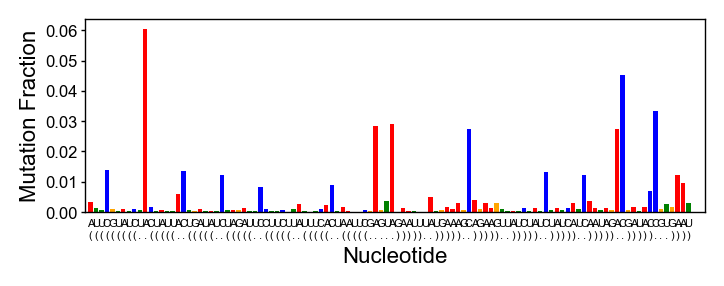

In [60]:
fig, ax = plt.subplots(figsize=(4.00, 1.25), dpi=200)
figure_1b(df_construct, ax)

#### Figure 1C: mutation fractions of DMS reactivity are highly reproducible

In [61]:
def figure_1c(df_construct, df_construct_2, ax):
    # prepare data for plot
    df_data = generate_replicate_df(df_construct, df_construct_2)
    # generate plot
    plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
    ax.set_xlabel("Mut. Frac. Run 1", labelpad=2)
    ax.set_ylabel("Mut. Frac. Run 2", labelpad=2)
    ax.set_xticks([0.00, 0.20, 0.40])
    ax.set_yticks([0.00, 0.20, 0.40])
    format_small_plot(ax)

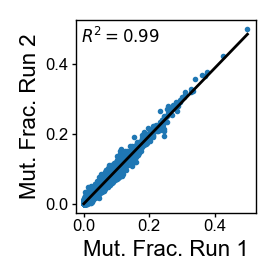

In [62]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1c(df_construct, df_construct_2, ax)

#### Figure 1D: histogram of DMS reactivity in Ln space visualize the distribution over the five orders of magnitude

In [63]:
# TODO add line for nomod average
def figure_1d(df, ax):
    ax.hist(df["ln_r_data"], bins=25)
    ax.set_yscale("log")
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_yticks([10, 100, 1000, 10000])
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)

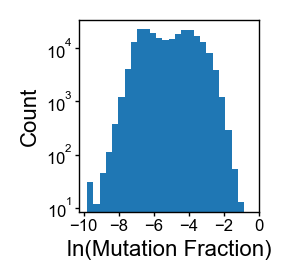

In [64]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1d(df, ax)

#### Figure 1E: how often does each motif occur

In [65]:
def figure_1e(df_motif, ax):
    data = []
    for i, group in df_motif.groupby("m_sequence"):
        data.append([i, len(group)])
    df_counts = pd.DataFrame(data, columns=["m_sequence", "count"])
    ax.set_xlabel("Motif Count", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    plt.hist(df_counts["count"], bins=100)
    format_small_plot(ax)

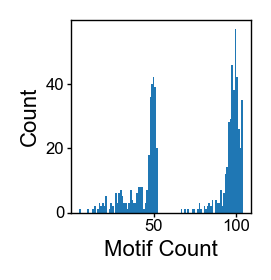

In [66]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1e(df_motif, ax)

#### Figure 1F: example motif's DMS reactivity over all constructs

In [67]:
def figure_1f(df, ax):
    df_motif_example = df[df["m_sequence"] == "GGGAAAG&UAACAC"]
    plot_motif_boxplot_stripplot(df_motif_example, ax=ax)
    ax.set_xlabel("Residues", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)
    # Add N = number of data instances in the top left corner
    n_instances = len(df_motif_example.query("r_loc_pos == 4"))
    ax.text(
        0.03,
        0.97,
        f"N = {n_instances}",
        transform=ax.transAxes,
        verticalalignment="top",
        fontsize=8,
    )
    format_small_plot(ax)

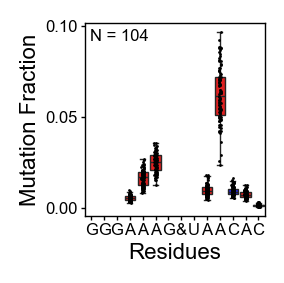

In [68]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1f(df, ax)

#### Figure 1G: reactivity avg vs std

In [69]:
def figure_1g(df, ax):
    data = []
    for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
        data.append([group["r_data"].mean(), group["r_data"].std()])
    df_data = pd.DataFrame(data, columns=["mean", "std"])
    plot_scatter_w_best_fit_line(np.log(df_data["mean"]), np.log(df_data["std"]), ax=ax)
    ax.set_xlabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_ylabel("ln(Std. Mut. Frac.)", labelpad=2)
    ax.set_yticks([-2, -4, -6, -8])
    ax.set_xticks([-8, -6, -4, -2])
    format_small_plot(ax)

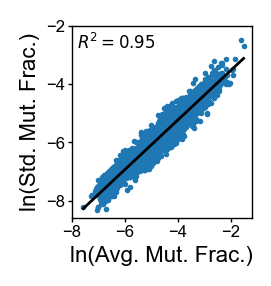

In [70]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1g(df, ax)

#### Figure 1H: coefficient of variation

In [71]:
def figure_1h(df, ax):
    data = []
    for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
        data.append(group["r_data"].std() / group["r_data"].mean())
    plt.hist(data, bins=50)
    format_small_plot(ax)
    ax.set_xlabel("Coefficient of Variation", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)

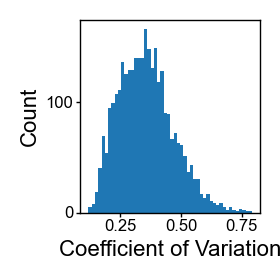

In [72]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1h(df, ax)

### Supplemental Figures / Information

#### Supplemental Figure 1: histogram of number of reads per construct

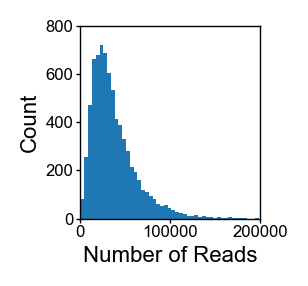

In [73]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
plt.hist(df_construct["num_aligned"], bins=100)
ax.set_xlabel("Number of Reads", labelpad=2)
ax.set_ylabel("Count", labelpad=2)
ax.set_xlim([0, 200000])
ax.set_xticks([0, 100000, 200000])
ax.set_yticks(range(0, 1000, 200))
format_small_plot(ax)

#### Supplemental Figure 2: Correlation between DMS reactivity and nomod

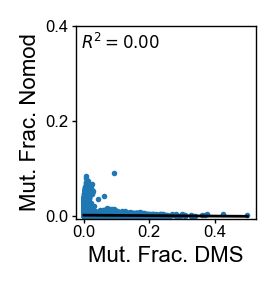

In [74]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
df_data = generate_replicate_df(df_construct, df_contruct_nomod)
plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
ax.set_xlabel("Mut. Frac. DMS", labelpad=2)
ax.set_ylabel("Mut. Frac. Nomod", labelpad=2)
ax.set_xticks([0.00, 0.20, 0.40])
ax.set_yticks([0.00, 0.20, 0.40])
format_small_plot(ax)

#### Supplemental Figure XXX: what is the relationship between DMS reactivity and the standard deviation of DMS reactivity for a given residue

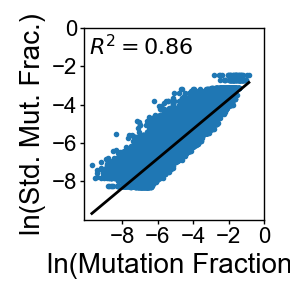

In [75]:
data = []
for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
    std = group["r_data"].std()
    if std == 0:
        continue
    for _, row in group.iterrows():
        if row["r_data"] == 0:
            continue
        data.append([row["r_data"], std])
df_data = pd.DataFrame(data, columns=["r_data", "std"])
df_data["ln_r_data"] = np.log(df_data["r_data"])

fig, ax = plt.subplots(figsize=(1.5, 1.25), dpi=200)
plot_scatter_w_best_fit_line(np.log(df_data["r_data"]), np.log(df_data["std"]), ax=ax)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_ylabel("ln(Std. Mut. Frac.)", labelpad=2)
ax.set_xticks([-8, -6, -4, -2, 0])
ax.set_yticks([-8, -6, -4, -2, 0])
format_small_plot(ax)
publication_style_ax(ax)

## DMS reactivity values are continuous, and a significant overlap exists between Watson-Crick and non-canonical interactions.

### Outline

### Analysis

#### 2a - logistic regression to determine if DMS reactivity cutoff for WC vs non-WC


In [76]:
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df["r_type_binary"] = df["r_type"].apply(lambda x: 1 if x == "WC" else 0)
# Fit the logistic regression model
model = LogisticRegression()
model.fit(df[["ln_r_data"]], df["r_type_binary"])
# Compute probabilities for the original data
df["prob_WC"] = model.predict_proba(df[["ln_r_data"]])[:, 1]
# Display the probabilities
df.sort_values("prob_WC", ascending=False)[["ln_r_data", "r_type", "prob_WC"]]

,ln_r_data,r_type,prob_WC
161014,-9.800000,WC,0.999997
18117,-9.800000,WC,0.999997
34407,-9.800000,WC,0.999997
164206,-9.800000,WC,0.999997
88932,-9.800000,WC,0.999997
...,...,...,...
234172,-1.076254,NON-WC,0.000003
234215,-1.013022,NON-WC,0.000002
234191,-0.994414,NON-WC,0.000002
55879,-0.972755,NON-WC,0.000002


#### 2b - 50% probability cutoff for WC vs non-WC

In [77]:
# Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
df["abs_diff"] = (df["prob_WC"] - 0.50).abs()

# Find the index of the minimum difference
min_index = df["abs_diff"].idxmin()

# Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
closest_row = df.loc[min_index]

print("The row with the value in 'prob_WC' closest to 0.5 is:")
print(closest_row["ln_r_data"])

The row with the value in 'prob_WC' closest to 0.5 is:
-5.47505454504809


#### 2c - how many residues are within 0.5 probability cutoff

In [78]:
percent_non_wc = len(df.query("ln_r_data < -5.45 and r_type == 'NON-WC'")) / len(
    df.query("r_type == 'NON-WC'")
)
print(f"% of non-WC below 0.5 probability cutoff: {percent_non_wc}")
percent_wc = len(df.query("ln_r_data > -5.45 and r_type == 'WC'")) / len(
    df.query("r_type == 'WC'")
)
print(f"% of WC above 0.5 probability cutoff: {percent_wc}")

% of non-WC below 0.5 probability cutoff: 0.08929956920439515
% of WC above 0.5 probability cutoff: 0.09870405821214157


### Figure 2

### Supplemental Figures